# Predict the closing price, Model: SARIMAX, Stock Token: FPT, Train/Test/Validation/: 70/20/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 873.64
- MAE: 557.74
- MAPE: 0.80 %

### Import neccesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Choose the split_type and stock_name -> FPT - 7 2 1
split = 0  # 7 2 1
stock = 0  # FPT

## 1.Data preprocessing


In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,19240,19270,19080,19270,590780,FPT
1,2019-03-04,19270,19520,19270,19440,806770,FPT
2,2019-03-05,19440,19520,19350,19390,824300,FPT
3,2019-03-06,19410,19480,19210,19270,695230,FPT
4,2019-03-07,19270,19440,19270,19330,374340,FPT
...,...,...,...,...,...,...,...
1247,2024-02-26,103900,108000,103500,108000,4466700,FPT
1248,2024-02-27,108500,109500,107400,107900,2800800,FPT
1249,2024-02-28,108000,108500,106300,108500,3461700,FPT
1250,2024-02-29,108200,109400,107700,109000,2824800,FPT


In [5]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1247,103500,108000
1248,107400,107900
1249,106300,108500
1250,107700,109000


In [6]:
df.reset_index(drop=True)
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1247,103500,108000
1248,107400,107900
1249,106300,108500
1250,107700,109000


In [7]:
# Shape of the dataframe
df.shape

(1252, 2)

In [8]:
df.dtypes

low      int64
close    int64
dtype: object

In [9]:
# Describe the dataframe
df.describe()

,low,close
count,1252.000000,1252.000000
mean,53176.075879,53761.785144
std,23775.452690,24036.800576
min,19080.000000,19190.000000
25%,28000.000000,28170.000000
50%,61120.000000,62070.000000
75%,69047.500000,69670.000000
max,109100.000000,110800.000000


## 2. Train model


In [10]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [11]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [12]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

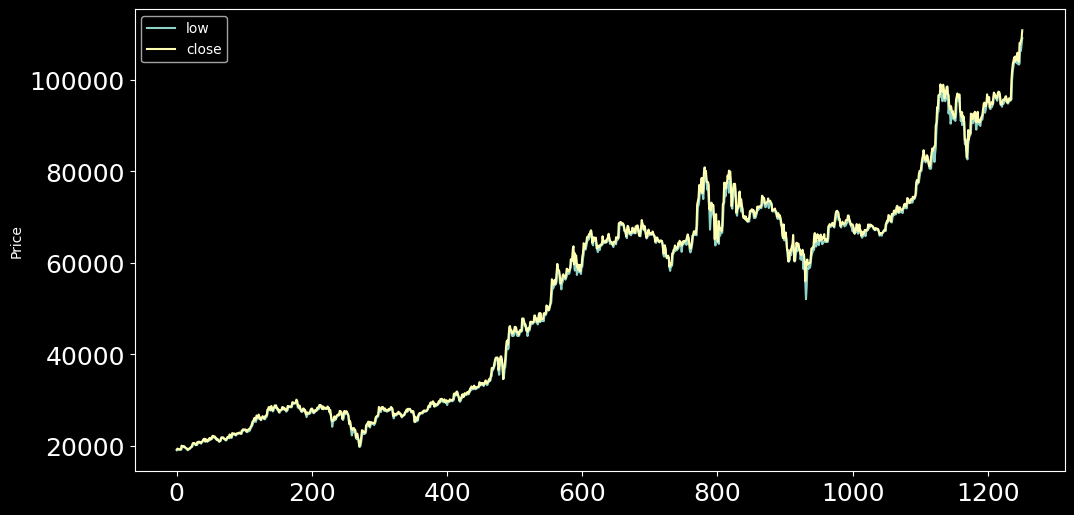

In [13]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [14]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(0.7303295005214733,
 0.9904241120961623,
 15,
 1236,
 {'1%': -3.435651725648415,
  '5%': -2.863881223119536,
  '10%': -2.568016498910778},
 20395.460496469426)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [15]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [16]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.792
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.748
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


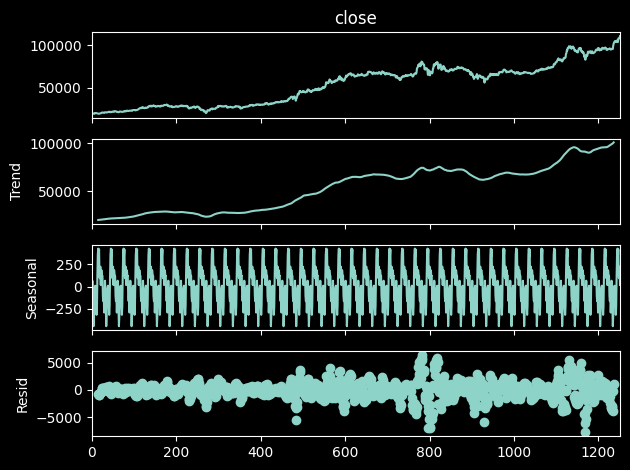

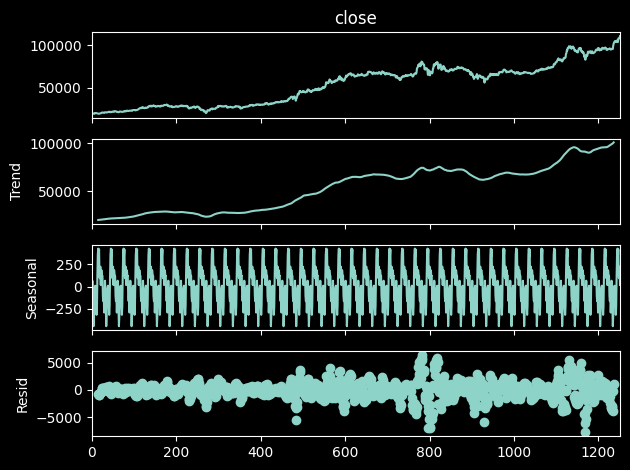

In [17]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [18]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [19]:
# Check again
adfuller(df_diff)

(-7.674921650769982,
 1.5579820323707916e-11,
 20,
 854,
 {'1%': -3.43803040357387,
  '5%': -2.864930295955726,
  '10%': -2.568575256706284},
 14000.342519825754)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

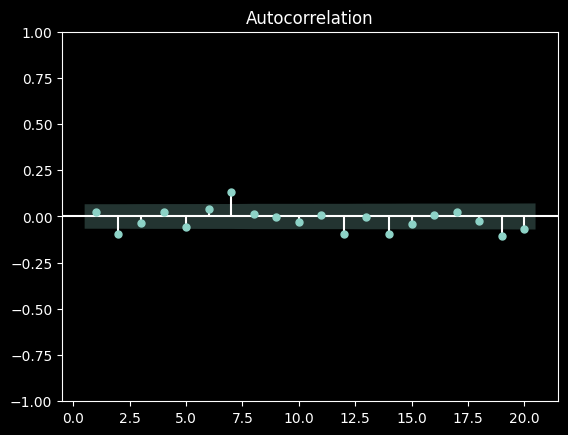

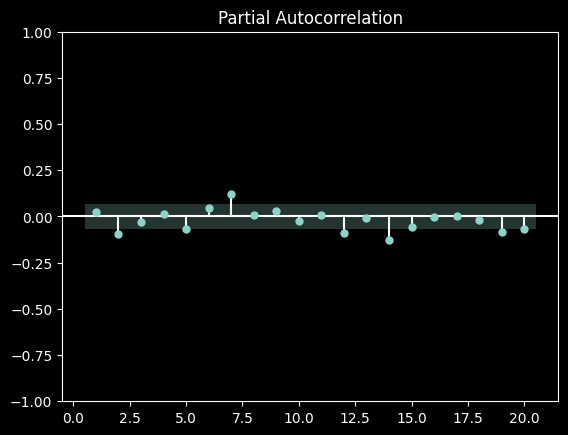

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [21]:
# Review the dataset again
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1247,103500,108000
1248,107400,107900
1249,106300,108500
1250,107700,109000


In [22]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=14369.657, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=14372.341, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=14372.834, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=14372.488, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=14374.662, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=14370.883, Time=0.43 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=14371.017, Time=0.36 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=14356.819, Time=1.80 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=14371.375, Time=0.71 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=14365.949, Time=1.91 sec
 ARIMA(1,1,2)(1,0,2)[5] intercept   : AIC=14372.399, Time=0.70 sec
 ARIMA(2,1,1)(1,0,2)[5] intercept   : AIC=14371.609, Time=0.68 sec
 ARIMA(3,1,2)(1,0,2)[5] intercept   : AIC=14357.051, Time=1.97 sec
 ARIMA(2,1,3)(1,0,2)[5] i

In [23]:
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  876
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 5)   Log Likelihood               -7169.410
Date:                           Sat, 25 May 2024   AIC                          14356.819
Time:                                   22:39:07   BIC                          14399.787
Sample:                                        0   HQIC                         14373.255
                                           - 876                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     68.1183     44.268      1.539      0.124     -18.645     154.881
ar.L1         -0.9382      0.019    -48.226

#### Use SARIMAX to train model


In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(2, 1, 2),
    seasonal_order=(1, 0, 2, 5),
)

model_fit = model1.fit()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [35]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([72534.20777794, 73582.12506635, 73421.72220773, 73561.40642348,
       73384.51578025, 72024.81909774, 71760.55023268, 72119.97235821,
       72142.45916677, 72189.57727332, 71551.119207  , 71693.08390139,
       70621.23242755, 70163.38463289, 70500.70548754, 70538.47177372,
       70174.17955517, 70309.33413542, 68810.93390917, 69009.45038935,
       66923.95130776, 66072.59559864, 65968.3695532 , 65560.48515256,
       66234.72568182, 67256.22166664, 65653.0267242 , 63546.17274674,
       61963.51456918, 61047.31999927, 61052.1074593 , 61470.03617921,
       63211.86704971, 62381.7896112 , 63555.37910203, 64153.91677002,
       64648.41017037, 63472.83277075, 61041.09275594, 61134.13396033,
       62475.41559328, 63310.44972351, 64142.55894858, 63308.62794631,
       64392.49953513, 63558.74706745, 63308.99991035, 61465.8523188 ,
       62382.11209379, 61379.51559735, 62975.72143877, 59458.75770669,
       61879.37719628, 60206.51046823, 56788.93131746, 52929.60318947,
      

#### Validate


In [36]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([ 93050.10808303,  93310.08872986,  96271.8848135 ,  97012.37071845,
        96431.66254641,  97859.29173348,  97171.50692357,  95442.89694892,
        97533.71744163,  97580.83554818,  95740.77410344,  95508.46889309,
        95845.05416608,  96076.6509328 ,  98649.74200792,  96520.68252976,
        92837.20720856,  94489.13982385,  93315.76346225,  90677.70803275,
        91675.01106133,  93039.72715665,  92226.3581338 ,  91749.52927701,
        91557.03950054,  91869.39250794,  91260.96757549,  92433.8998686 ,
        95588.71074852,  96090.80213346,  96194.08167368,  95499.04988736,
        96472.64253233,  93328.00120918,  91261.20126152,  92253.7072503 ,
        90374.5415179 ,  91060.464434  ,  91061.47880007,  91164.36921248,
        86340.04662508,  86633.37431423,  85347.90381505,  83381.31389051,
        82987.80427637,  86241.47313688,  87321.36906245,  88107.96001216,
        88206.73552151,  88602.72656388,  92050.583513  ,  91557.32664298,
        90767.10431813,  

### Predict the next 30/60/90 days


In [37]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [38]:
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1247,103500,108000
1248,107400,107900
1249,106300,108500
1250,107700,109000


In [41]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[100761.47872319 100796.02723808 100873.10502445 100994.19047666
 100975.98681426 101193.26306742 101166.47484735 101182.2743447
 101274.80526191 101391.96747711 101493.29966478 101528.02272347
 101540.68378431 101645.34049929 101727.68159794 101835.49199276
 101866.26774751 101913.8791081  101992.45181751 102083.72666199
 102166.15299725 102222.02407846 102266.63580583 102352.31145868
 102426.84995125 102513.77082671 102566.3424841  102627.41392349
 102700.52234575 102780.19743835]


### Plotting the data


In [42]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

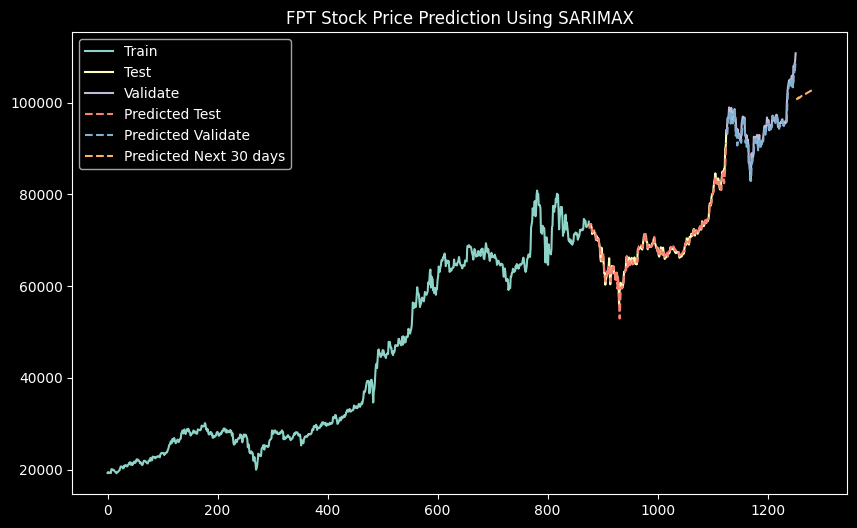

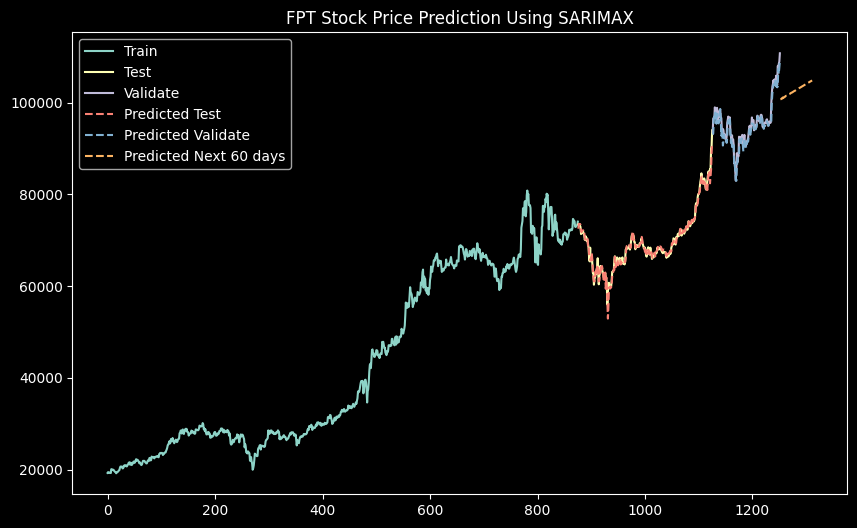

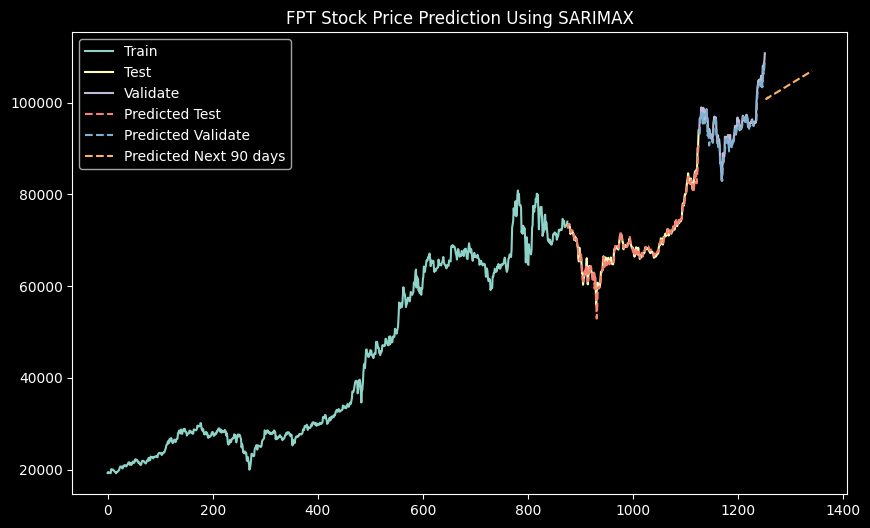

In [43]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [44]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 873.6405248807906
MAE on test data: 557.7387416633882
MAPE on test data: 0.8028687329927092 %


In [45]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 1283.3865093067782
MAE on validation data: 857.2885965402402
MAPE on validation data: 0.8892025712867511 %
